In [1]:
!pip install dash pyarrow sqlite3 pandas plotly statsmodels

  Using cached dash-3.0.4-py3-none-any.whl.metadata (10 kB)
ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [2]:
# stage1_bronze.py

import zipfile, os, io
import pandas as pd

# 1. Read the raw CSV
csv_path = '/content/superstore.csv'
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# 2. Drop duplicates
df = df.drop_duplicates()

# 3. Parse date columns
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date']  = pd.to_datetime(df['Ship Date'],  errors='coerce')

# 4. Trim whitespace on string columns
str_cols = [
    'Order ID','Customer ID','Customer Name','Segment','City','State','Country','Region',
    'Product ID','Category','Sub-Category','Product Name','Ship Mode'
]
for c in str_cols:
    if c in df:
        df[c] = df[c].astype(str).str.strip()

# 5. Convert numeric columns
for c in ['Sales','Quantity','Discount','Profit']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# 6. Drop rows missing critical fields
df = df.dropna(subset=['Order Date','Customer ID','Order ID'])

# 7. Derive Bronze-level time fields
df['Order_Month'] = df['Order Date'].dt.to_period('M').astype(str)
df['Order_Year']  = df['Order Date'].dt.year

# 8. Save Bronze layer
df.to_parquet('bronze_superstore.parquet', index=False)
print("Stage 1 complete: bronze_superstore.parquet created with", len(df), "rows.")


Stage 1 complete: bronze_superstore.parquet created with 9994 rows.


In [3]:
# stage2_silver.py


# 1. Load Bronze layer
df = pd.read_parquet('bronze_superstore.parquet')

# 2. Add Silver‐level derived columns
df['Profit_Margin'] = df['Profit'] / df['Sales']

# 3. Category‐level metrics
cat_metrics = df.groupby('Category').agg(
    total_sales=('Sales','sum'),
    total_profit=('Profit','sum'),
    avg_discount=('Discount','mean'),
    avg_margin=('Profit_Margin','mean')
).reset_index()

# 4. Region‐level metrics
region_metrics = df.groupby('Region').agg(
    total_sales=('Sales','sum'),
    total_profit=('Profit','sum'),
    avg_margin=('Profit_Margin','mean')
).reset_index()

# 5. Monthly trend metrics
monthly_metrics = df.groupby('Order_Month').agg(
    total_sales=('Sales','sum'),
    total_profit=('Profit','sum'),
    avg_margin=('Profit_Margin','mean')
).reset_index().sort_values('Order_Month')

# 6. Top 10 Customers by sales
cust_metrics = df.groupby('Customer Name').agg(
    total_sales=('Sales','sum'),
    total_profit=('Profit','sum')
).reset_index().sort_values('total_sales', ascending=False).head(10)

# 7. Save Silver tables
cat_metrics.to_parquet('silver/category_metrics.parquet', index=False)
region_metrics.to_parquet('silver/region_metrics.parquet', index=False)
monthly_metrics.to_parquet('silver/monthly_metrics.parquet', index=False)
cust_metrics.to_parquet('silver/customer_metrics.parquet', index=False)

print("Stage 2 complete: silver/*.parquet files written.")


Stage 2 complete: silver/*.parquet files written.


In [4]:
# stage3_gold.py

import sqlite3

# 1. Read Silver tables
cat = pd.read_parquet('silver/category_metrics.parquet')
reg = pd.read_parquet('silver/region_metrics.parquet')
mon = pd.read_parquet('silver/monthly_metrics.parquet')
cust = pd.read_parquet('silver/customer_metrics.parquet')

# 2. Build Dimensions

# dim_category
dim_category = cat[['Category']].drop_duplicates().reset_index(drop=True)
dim_category['category_id'] = dim_category.index + 1

# dim_region
dim_region = reg[['Region']].drop_duplicates().reset_index(drop=True)
dim_region['region_id'] = dim_region.index + 1

# dim_date (from monthly metrics)
dim_date = mon[['Order_Month']].drop_duplicates().reset_index(drop=True)
dim_date['date_id'] = dim_date.index + 1
dim_date[['year','month']] = dim_date['Order_Month'].str.split('-', expand=True).astype(int)

# 3. Build Fact Tables

# fact_category
fact_category = (
    cat.merge(dim_category, on='Category')
    [['category_id','total_sales','total_profit','avg_discount','avg_margin']]
)

# fact_region
fact_region = (
    reg.merge(dim_region, on='Region')
    [['region_id','total_sales','total_profit','avg_margin']]
)

# fact_monthly
fact_monthly = (
    mon.merge(dim_date, left_on='Order_Month', right_on='Order_Month')
    [['date_id','total_sales','total_profit','avg_margin']]
)

# fact_customer
fact_customer = cust.copy()
fact_customer['customer_id'] = fact_customer.index + 1
fact_customer = fact_customer[['customer_id','total_sales','total_profit']]

# 4. Load into SQLite
conn = sqlite3.connect('gold_superstore.db')

dim_category.to_sql('dim_category', conn, index=False, if_exists='replace')
dim_region.to_sql('dim_region', conn, index=False, if_exists='replace')
dim_date.to_sql('dim_date',     conn, index=False, if_exists='replace')

fact_category.to_sql('fact_category', conn, index=False, if_exists='replace')
fact_region.to_sql('fact_region',     conn, index=False, if_exists='replace')
fact_monthly.to_sql('fact_monthly',   conn, index=False, if_exists='replace')
fact_customer.to_sql('fact_customer', conn, index=False, if_exists='replace')

conn.close()
print("Stage 3 complete: gold_superstore.db created with dims and facts.")


Stage 3 complete: gold_superstore.db created with dims and facts.


In [5]:
!pip install dash pandas plotly


  Using cached dash-3.0.4-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [6]:
import plotly.express as px
from dash import Dash, dcc, html
bronze = pd.read_parquet('bronze_superstore.parquet')
print("Bronze rows:", len(bronze))
print(bronze.dtypes)

print(bronze[['Order Date','Customer ID','Order ID']].isnull().sum())

dupes = bronze.duplicated().sum()
print("Bronze duplicate rows:", dupes)

for fn in [
    'silver/category_metrics.parquet',
    'silver/region_metrics.parquet',
    'silver/monthly_metrics.parquet',
    'silver/customer_metrics.parquet',
]:
    df = pd.read_parquet(fn)
    print(fn, "→ rows:", len(df))
    print(df.head(2), "\n")


conn = sqlite3.connect('gold_superstore.db')

# a) List all tables
tbls = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tbls)

# b) Row counts per table
for t in tbls['name']:
    cnt = pd.read_sql(f"SELECT COUNT(*) AS cnt FROM {t};", conn).iloc[0,0]
    print(f"{t}: {cnt} rows")

# c) Referential integrity spot‐check
#   fact_monthly.date_id must exist in dim_date
bad = pd.read_sql("""
SELECT COUNT(*) AS orphan_dates
  FROM fact_monthly f
  LEFT JOIN dim_date d ON f.date_id = d.date_id
 WHERE d.date_id IS NULL;
""", conn).iloc[0,0]
print("fact_monthly → orphan date_ids:", bad)

# d) Preview each table
for t in tbls['name']:
    print(t, pd.read_sql(f"SELECT * FROM {t} LIMIT 3;", conn), "\n")

conn.close()


Bronze rows: 9994
Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
Order_Month              object
Order_Year                int32
dtype: object
Order Date     0
Customer ID    0
Order ID       0
dtype: int64
Bronze duplicate rows: 0
silver/category_metrics.parquet → rows: 3
          Category  total_sales  total_profit  avg_discount  avg_margin
0        Furniture  741999.79

In [7]:

# 1. Read from SQLite warehouse
conn = sqlite3.connect('gold_superstore.db')

# Use d.Order_Month (as month_code) instead of d.month_code
monthly = pd.read_sql(
    """
    SELECT
      d.Order_Month AS month_code,
      f.total_sales,
      f.total_profit
    FROM fact_monthly f
    JOIN dim_date d
      ON f.date_id = d.date_id
    ORDER BY month_code
    """, conn)

category = pd.read_sql(
    """
    SELECT
      c.category      AS category,
      f.total_sales,
      f.total_profit,
      f.avg_discount,
      f.avg_margin
    FROM fact_category f
    JOIN dim_category c
      ON f.category_id = c.category_id
    """, conn)

region = pd.read_sql(
    """
    SELECT
      r.region       AS region,
      f.total_sales,
      f.total_profit,
      f.avg_margin
    FROM fact_region f
    JOIN dim_region r
      ON f.region_id = r.region_id
    """, conn)

customers = pd.read_sql(
    """
    SELECT
      customer_id,
      total_sales,
      total_profit
    FROM fact_customer
    ORDER BY total_sales DESC
    LIMIT 10
    """, conn)

conn.close()

# 2. Create figures
fig_month = px.line(
    monthly, x='month_code', y=['total_sales','total_profit'],
    title='Monthly Sales & Profit Trend',
    labels={'value':'USD','month_code':'Month'}
)

fig_cat = px.bar(
    category, x='category', y='total_sales',
    title='Sales by Category',
    hover_data=['total_profit','avg_margin'],
    labels={'total_sales':'Sales'}
)

fig_reg = px.bar(
    region, x='region', y='total_sales',
    title='Sales by Region',
    hover_data=['total_profit','avg_margin'],
    labels={'total_sales':'Sales'}
)

fig_cust = px.bar(
    customers, x='customer_id', y='total_sales',
    title='Top 10 Customers by Sales',
    labels={'total_sales':'Sales'}
)

# 3. Build Dash App
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Superstore Analytics Dashboard"),
    dcc.Graph(figure=fig_month),
    html.Div([
        dcc.Graph(figure=fig_cat, style={'display':'inline-block','width':'49%'}),
        dcc.Graph(figure=fig_reg, style={'display':'inline-block','width':'49%'})
    ]),
    dcc.Graph(figure=fig_cust)
])

if __name__ == '__main__':
    app.run(port = 8050, debug=True)


<IPython.core.display.Javascript object>

Top 10 Customers by RFM Score:


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment
787,WB-21850,21,11,6160.1020,4,4,4,12,444
786,VW-21775,29,10,6134.0380,4,4,4,12,444
328,HM-14860,3,10,8236.7648,4,4,4,12,444
702,SM-20950,26,12,5563.3920,4,4,4,12,444
65,BB-11545,29,9,6765.7280,4,4,4,12,444
215,DK-13225,11,9,4802.3940,4,4,4,12,444
59,AT-10735,14,10,3831.8640,4,4,4,12,444
387,JL-15835,22,11,9799.9230,4,4,4,12,444
233,DR-12880,4,9,6528.0340,4,4,4,12,444
365,JG-15160,2,11,6366.3920,4,4,4,12,444


Cohort Retention Table (proportions):


CohortIndex,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
Cohort_Month,,,,,,,,,,,,,,,,,,,,,
2014-01,1.0,0.094,NaN,0.062,0.062,NaN,0.062,0.125,0.156,0.094,...,0.188,0.125,0.156,0.125,0.031,0.062,0.281,0.281,0.312,0.188
2014-02,1.0,0.167,0.083,0.042,NaN,0.083,0.083,0.125,0.125,0.167,...,0.083,0.083,0.208,0.125,0.125,0.167,0.250,0.250,0.125,NaN
2014-03,1.0,0.062,0.031,0.123,0.108,NaN,0.108,0.077,0.123,0.092,...,0.200,0.154,0.185,0.092,0.292,0.123,0.277,0.246,NaN,NaN
2014-04,1.0,0.107,0.036,0.071,0.054,0.143,0.107,0.161,0.143,0.018,...,0.089,0.125,0.143,0.268,0.143,0.250,0.250,NaN,NaN,NaN
2014-05,1.0,0.089,0.089,0.071,0.179,0.036,0.214,0.179,0.071,0.054,...,0.125,0.107,0.286,0.125,0.304,0.161,NaN,NaN,NaN,NaN
2014-06,1.0,0.021,0.042,0.083,0.042,0.188,0.167,0.021,0.083,0.125,...,0.062,0.271,0.146,0.292,0.229,NaN,NaN,NaN,NaN,NaN
2014-07,1.0,0.136,0.114,NaN,0.114,0.182,0.045,NaN,0.182,0.045,...,0.250,0.227,0.295,0.205,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,1.0,0.163,0.061,0.224,0.102,0.061,0.082,0.041,0.082,0.061,...,0.245,0.224,0.204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,1.0,0.132,0.132,0.162,0.015,0.029,0.132,0.147,0.132,0.029,...,0.235,0.176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Discount vs Profit Margin by Bin:


,Discount_Bin,avg_discount,profit_margin
0,0-10%,0.001922,0.288911
1,10-20%,0.199299,0.115832
2,20-30%,0.300000,-0.100452
3,30-50%,0.416097,-0.248049
4,50-100%,0.718925,-1.191975


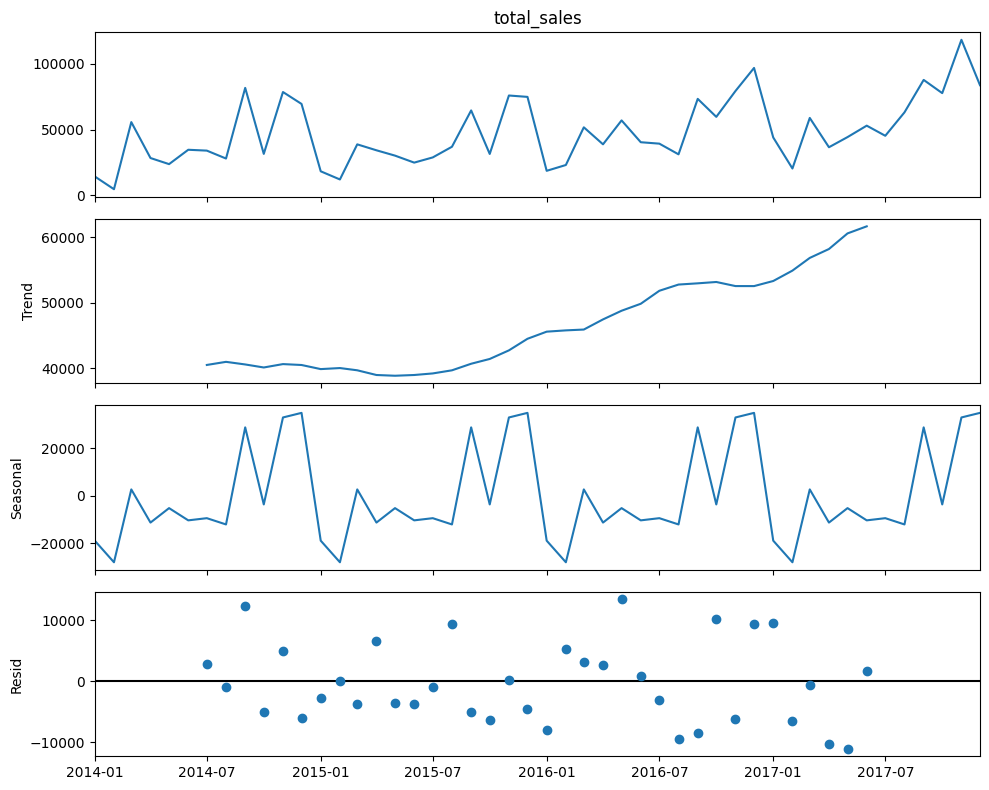

6-Month Sales Forecast:


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



,Month,Forecast_Sales
0,2018-01-01,50321.382449
1,2018-02-01,42480.259261
2,2018-03-01,74560.388209
3,2018-04-01,61838.886811
4,2018-05-01,69236.677656
5,2018-06-01,65358.588777


In [8]:

from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from IPython.display import display

# Load cleaned Bronze data
bronze = pd.read_parquet('bronze_superstore.parquet')

# 1. RFM Segmentation
snapshot_date = bronze['Order Date'].max() + timedelta(days=1)
rfm = bronze.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
}).reset_index().rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
})

# Compute quantiles
quantiles = rfm[['Recency','Frequency','Monetary']].quantile([.25, .5, .75]).to_dict()

def r_score(x):
    if x <= quantiles['Recency'][0.25]: return 4
    elif x <= quantiles['Recency'][0.50]: return 3
    elif x <= quantiles['Recency'][0.75]: return 2
    else: return 1

def fm_score(x, col):
    if x <= quantiles[col][0.25]: return 1
    elif x <= quantiles[col][0.50]: return 2
    elif x <= quantiles[col][0.75]: return 3
    else: return 4

rfm['R_Score'] = rfm['Recency'].apply(r_score)
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: fm_score(x,'Frequency'))
rfm['M_Score'] = rfm['Monetary'].apply(lambda x: fm_score(x,'Monetary'))
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']
rfm['RFM_Segment'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)

print("Top 10 Customers by RFM Score:")
display(rfm.sort_values('RFM_Score', ascending=False).head(10))

# 2. Cohort Analysis
bronze['Order_Month'] = bronze['Order Date'].dt.to_period('M')
user_cohorts = bronze[['Customer ID','Order_Month']].drop_duplicates()
user_cohorts['Cohort_Month'] = user_cohorts.groupby('Customer ID')['Order_Month'].transform('min')

cohort_counts = user_cohorts.groupby(['Cohort_Month','Order_Month'], observed=True) \
    .agg(n_customers=('Customer ID','nunique')).reset_index()
cohort_counts['CohortIndex'] = ((cohort_counts['Order_Month'] - cohort_counts['Cohort_Month'])
                                  .apply(lambda x: x.n))
cohort_pivot = cohort_counts.pivot_table(
    index='Cohort_Month',
    columns='CohortIndex',
    values='n_customers'
)
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0)

print("Cohort Retention Table (proportions):")
display(retention.round(3))

# 3. Discount Elasticity
bronze['Discount_Bin'] = pd.cut(
    bronze['Discount'],
    bins=[-0.01,0.1,0.2,0.3,0.5,1.0],
    labels=['0-10%','10-20%','20-30%','30-50%','50-100%']
)

discount_group = (
    bronze
    .groupby('Discount_Bin', observed=True)
    .agg(
        avg_discount=('Discount','mean'),
        total_profit=('Profit','sum'),
        total_sales=('Sales','sum')
    )
    .reset_index()
)
discount_group['profit_margin'] = discount_group['total_profit'] / discount_group['total_sales']

print("Discount vs Profit Margin by Bin:")
display(discount_group[['Discount_Bin','avg_discount','profit_margin']])

# 4. Seasonal Decomposition of Sales
monthly = pd.read_parquet('silver/monthly_metrics.parquet')
ts = monthly.set_index('Order_Month')['total_sales'].astype(float)
ts.index = pd.PeriodIndex(ts.index, freq='M').to_timestamp()

decomp = seasonal_decompose(ts, model='additive')
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.tight_layout()
plt.show()

# 5. 6-Month Sales Forecast
model = ExponentialSmoothing(ts, seasonal='add', trend='add', seasonal_periods=12).fit()
forecast = model.forecast(6)
forecast_df = forecast.reset_index().rename(columns={'index':'Month', 0:'Forecast_Sales'})

print("6-Month Sales Forecast:")
display(forecast_df)
